In [27]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import torch.nn.functional as F

In [19]:
df_mlp = pd.read_csv('../Data/encodedCTGAN.csv')

In [20]:
df_mlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111 entries, 0 to 1110
Data columns (total 58 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   Age                                                          1111 non-null   float64
 1   Hours per day                                                1111 non-null   float64
 2   BPM                                                          1111 non-null   float64
 3   Frequency [Classical]                                        1111 non-null   int64  
 4   Frequency [Country]                                          1111 non-null   int64  
 5   Frequency [EDM]                                              1111 non-null   int64  
 6   Frequency [Folk]                                             1111 non-null   int64  
 7   Frequency [Gospel]                                           1111 non-null   i

In [21]:
# Define the MLP Model

# Data
X = df_mlp.drop(['Music effects_Improve', 'Music effects_No effect', 'Music effects_Worsen'], axis=1).values
y = df_mlp[['Music effects_Improve', 'Music effects_No effect', 'Music effects_Worsen']].values

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Tensor datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [22]:
# Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.output_layer(x)
        return x
    
#     def forward(self, x):
#         x = torch.sigmoid(self.layer1(x))
#         x = torch.sigmoid(self.layer2(x))
#         x = self.output_layer(x)
#         return x

#     def forward(self, x):
#         x = torch.tanh(self.layer1(x))
#         x = torch.tanh(self.layer2(x))
#         x = self.output_layer(x)
#         return x


In [23]:
# Training
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # Calculate accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(y_batch.argmax(dim=1, keepdim=True)).sum().item()
    return total_loss / len(train_loader), correct / len(train_loader.dataset)


In [24]:
# Validation Function
def validate(model, device, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            total_loss += criterion(output, y_batch).item()
            # Calculate accuracy
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(y_batch.argmax(dim=1, keepdim=True)).sum().item()
    return total_loss / len(test_loader), correct / len(test_loader.dataset)


In [25]:
# Initialize Model, Optimizer, and Loss Function
input_dim = X.shape[1]
hidden_dim = 200
output_dim = y.shape[1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim, hidden_dim, output_dim).to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.RMSprop(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [29]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

losses, accuracies = [], []

for fold, (train_ids, test_ids) in enumerate(kf.split(X)):
    X_train, X_test = X[train_ids], X[test_ids]
    y_train, y_test = y[train_ids], y[test_ids]
    
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    for epoch in range(10):  # Number of epochs can be adjusted
        train_loss, train_acc = train(model, device, train_loader, optimizer, criterion)
        test_loss, test_acc = validate(model, device, test_loader, criterion)
        print(f'Fold {fold+1}, Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        losses.append((train_loss, test_loss))
        accuracies.append((train_acc, test_acc))


Fold 1, Epoch 1, Train Loss: 0.7113, Train Acc: 0.7477, Test Loss: 0.5815, Test Acc: 0.7848
Fold 1, Epoch 2, Train Loss: 0.6065, Train Acc: 0.7714, Test Loss: 0.5829, Test Acc: 0.7848
Fold 1, Epoch 3, Train Loss: 0.5888, Train Acc: 0.7714, Test Loss: 0.5903, Test Acc: 0.7848
Fold 1, Epoch 4, Train Loss: 0.5718, Train Acc: 0.7748, Test Loss: 0.5976, Test Acc: 0.7848
Fold 1, Epoch 5, Train Loss: 0.5493, Train Acc: 0.7770, Test Loss: 0.6123, Test Acc: 0.7848
Fold 1, Epoch 6, Train Loss: 0.5366, Train Acc: 0.7872, Test Loss: 0.6326, Test Acc: 0.7848
Fold 1, Epoch 7, Train Loss: 0.5044, Train Acc: 0.7883, Test Loss: 0.6394, Test Acc: 0.7713
Fold 1, Epoch 8, Train Loss: 0.4716, Train Acc: 0.8074, Test Loss: 0.6564, Test Acc: 0.7803
Fold 1, Epoch 9, Train Loss: 0.4286, Train Acc: 0.8221, Test Loss: 0.6941, Test Acc: 0.7668
Fold 1, Epoch 10, Train Loss: 0.3915, Train Acc: 0.8446, Test Loss: 0.7315, Test Acc: 0.7534
Fold 2, Epoch 1, Train Loss: 0.4459, Train Acc: 0.8335, Test Loss: 0.3284, Test

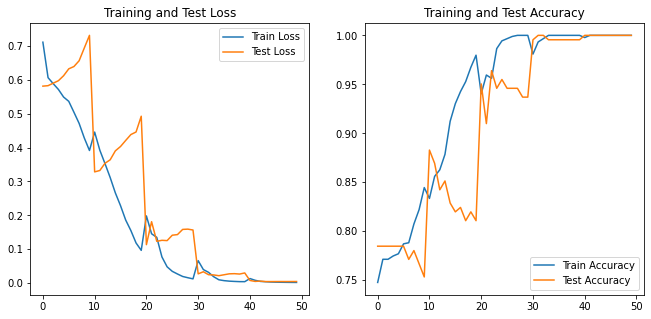

In [30]:
# Plotting the Results
train_losses, test_losses = zip(*losses)
train_accs, test_accs = zip(*accuracies)

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.show()